#  Autoencoding Fashion MNIST Data

## 1.0 Study purpose

* Build and train an autoencoder for the Fashion MNIST dataset.
* Compress the images into a lower-dimensional representation.
* Reconstruct the original images from the compressed representations.
* Monitor the reconstruction loss during training.
* Evaluate performance by visualizing reconstructed images.

## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Import libraries

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf

%matplotlib inline

In [127]:
from matplotlib import pyplot
from keras.datasets import mnist, fashion_mnist, cifar100
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense , Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.optimizers import Adam ,RMSprop
from keras import backend as K
from subprocess import check_output
from sklearn.preprocessing import label_binarize
from sklearn.metrics import label_ranking_average_precision_score

#### 2.1.2 Suppress warnings

In [128]:
warnings.filterwarnings('ignore')

#### 2.1.3 Data ingestion

In [129]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [130]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


#### 2.1.4 Set random seed

In [131]:
np.random.seed(42)

### 2.2 Data quality

#### 2.2.1 Training data sample images

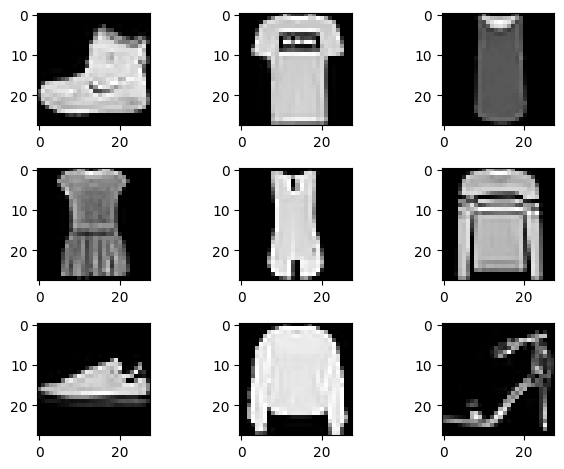

In [132]:
for i in range(9):
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))

pyplot.tight_layout()
pyplot.show()

#### 2.2.2 Training label data counts

In [133]:
unique, counts = np.unique(train_y, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

Train labels:  {np.uint8(0): np.int64(6000), np.uint8(1): np.int64(6000), np.uint8(2): np.int64(6000), np.uint8(3): np.int64(6000), np.uint8(4): np.int64(6000), np.uint8(5): np.int64(6000), np.uint8(6): np.int64(6000), np.uint8(7): np.int64(6000), np.uint8(8): np.int64(6000), np.uint8(9): np.int64(6000)}


#### 2.2.3 Testing label data counts

In [134]:
unique, counts = np.unique(test_y, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Test labels:  {np.uint8(0): np.int64(1000), np.uint8(1): np.int64(1000), np.uint8(2): np.int64(1000), np.uint8(3): np.int64(1000), np.uint8(4): np.int64(1000), np.uint8(5): np.int64(1000), np.uint8(6): np.int64(1000), np.uint8(7): np.int64(1000), np.uint8(8): np.int64(1000), np.uint8(9): np.int64(1000)}


#### 2.2.4 Label descriptions

1.	T-shirt/top
2.	Trouser
3.	Pullover
4.	Dress
5.	Coat
6.	Sandal
7.	Shirt
8.	Sneaker
9.	Bag
10.	Ankle boot

### 2.3 Exploratory data analysis

## 3.0 Data preprocessing

### 3.1 Compute the number of labels

In [135]:
num_labels = len(np.unique(train_y))
num_labels

10

### 3.2 Encode output data

In [136]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

### 3.3 Image dimensions

In [137]:
image_size = train_X.shape[1]
input_size = image_size * image_size
input_size

784

In [138]:
train_X = np.expand_dims(train_X, axis=-1)

### 3.4 Number of classes

In [139]:
num_classes = test_y.shape[1]

#### 3.5.1 Training data

In [140]:
train_X1 = np.reshape(train_X, [-1, input_size])
train_X1 = train_X1.astype('float32') / 255
train_X = train_X.astype('float32') / 255

In [141]:
print('X1_train: ' + str(train_X1.shape))
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

X1_train: (60000, 784)
X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)


#### 3.5.2 Testing data

In [142]:
test_X1 = np.reshape(test_X, [-1, input_size])
test_X1 = test_X1.astype('float32') / 255
test_X = test_X.astype('float32') / 255

In [143]:
print('X1_test:  '  + str(test_X1.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X1_test:  (10000, 784)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)


### 4.0 Modeling

### 4.1 Model input

In [144]:
input_img = Input(shape=(784,))

### 4.2 Encoder layers

In [145]:
e1 = Dense(256, activation='relu')(input_img)

In [146]:
e2 = Dense(128, activation='relu')(e1)

In [147]:
e3 = Dense(64, activation='relu')(e2)

In [148]:
encoded = Dense(32, activation='relu')(e3)

### 4.3 Decoder layers

In [149]:
d1 = Dense(64, activation='sigmoid')(encoded)

In [150]:
d2 = Dense(128, activation='sigmoid')(d1)

In [151]:
d3 = Dense(256, activation='sigmoid')(d2)

In [152]:
decoded = Dense(784, activation='sigmoid')(d3)

### 4.4 Autoencoder model

In [153]:
autoencoder = Model(input_img, decoded)

In [154]:
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,136 (1.87 MB)

 Trainable params: 489,136 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

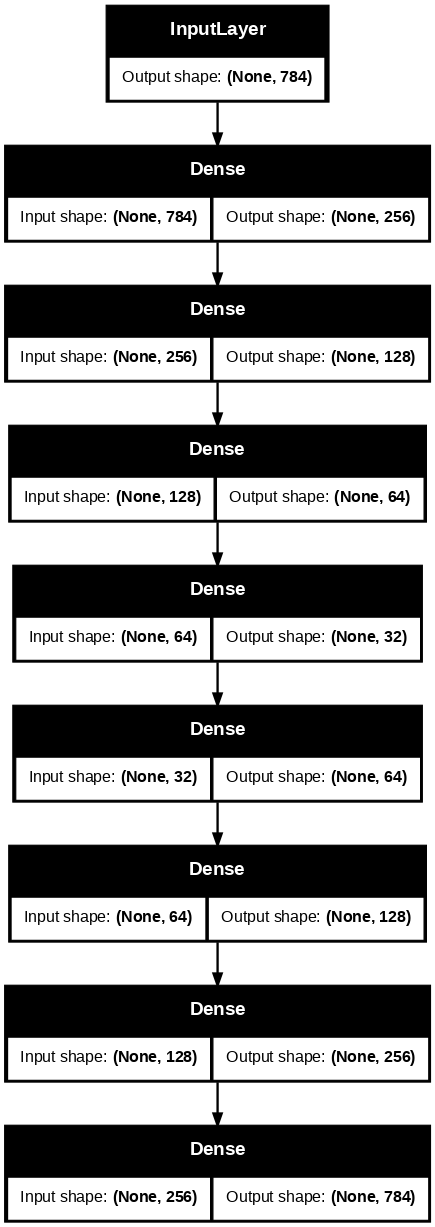

In [155]:
plot_model(autoencoder, to_file='mlp-fashion-mnist-encode.png', show_shapes=True, dpi=84)

### 4.5 Encoder model

In [156]:
encoder = Model(input_img, encoded)

### 4.6 Decoder model

In [157]:
latent_input = Input(shape=(32,), name="decoder_input")

In [158]:
x = Dense(64, activation='sigmoid')(latent_input)

In [159]:
x = Dense(128, activation='sigmoid')(x)

In [160]:
x = Dense(256, activation='sigmoid')(x)

In [161]:
decoded_output = Dense(784, activation='sigmoid')(x)

In [162]:
decoder = Model(latent_input, decoded_output)

### 4.6 Compile the autoencoder

In [163]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 4.7 Fit the autoencoder

In [164]:
autoencoder.fit(train_X1, train_X1,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(test_X1, test_X1),
                verbose=1)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.0066 - loss: 0.4372 - val_accuracy: 0.0057 - val_loss: 0.3477
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.0115 - loss: 0.3406 - val_accuracy: 0.0124 - val_loss: 0.3264
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.0122 - loss: 0.3198 - val_accuracy: 0.0152 - val_loss: 0.3127
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.0144 - loss: 0.3092 - val_accuracy: 0.0170 - val_loss: 0.3069
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0156 - loss: 0.3032 - val_accuracy: 0.0146 - val_loss: 0.3030
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.0156 - loss: 0.3009 - val_accuracy: 0.0167 - val_loss: 0.3006
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.0170 - loss: 0.2983 - val_accuracy: 0.0159 - val_loss: 0.2993
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.0190 - loss: 0.2958 - 

## 5.0 Evaluation

### 5.1 Plot image transformation

In [165]:
encoded_images = encoder.predict(test_X1)
predicted = autoencoder.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


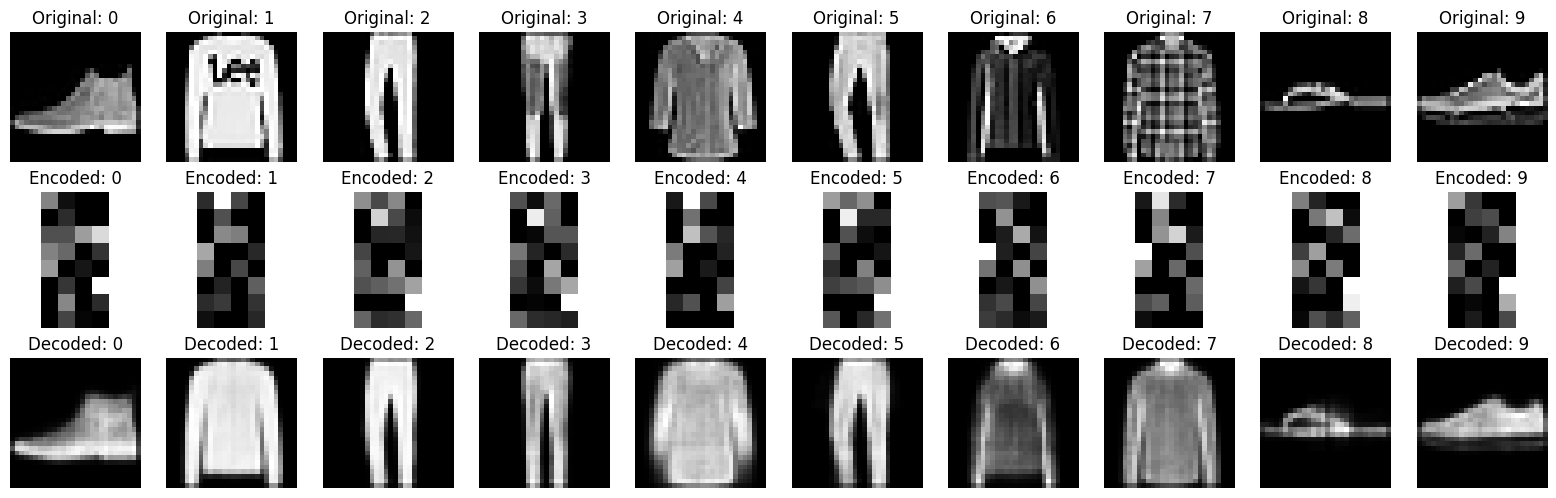

In [166]:
plt.figure(figsize=(40, 6))
for i in range(10):
  ax = plt.subplot(3, 20, i + 1)
  plt.imshow(test_X1[i].reshape(28, 28), cmap='gray')
  plt.title("Original: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, i + 1 + 20)
  plt.imshow(encoded_images[i].reshape(8, 4), cmap='gray')
  plt.title("Encoded: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, 2 * 20 + i + 1)
  plt.imshow(predicted[i].reshape(28, 28), cmap='gray')
  plt.title("Decoded: {}".format(i))
  plt.axis('off')
plt.show()

### 5.2 Plot latent space

In [167]:
mu = encoder.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [168]:
labels = np.argmax(test_y, axis=1) if test_y.ndim == 2 else test_y

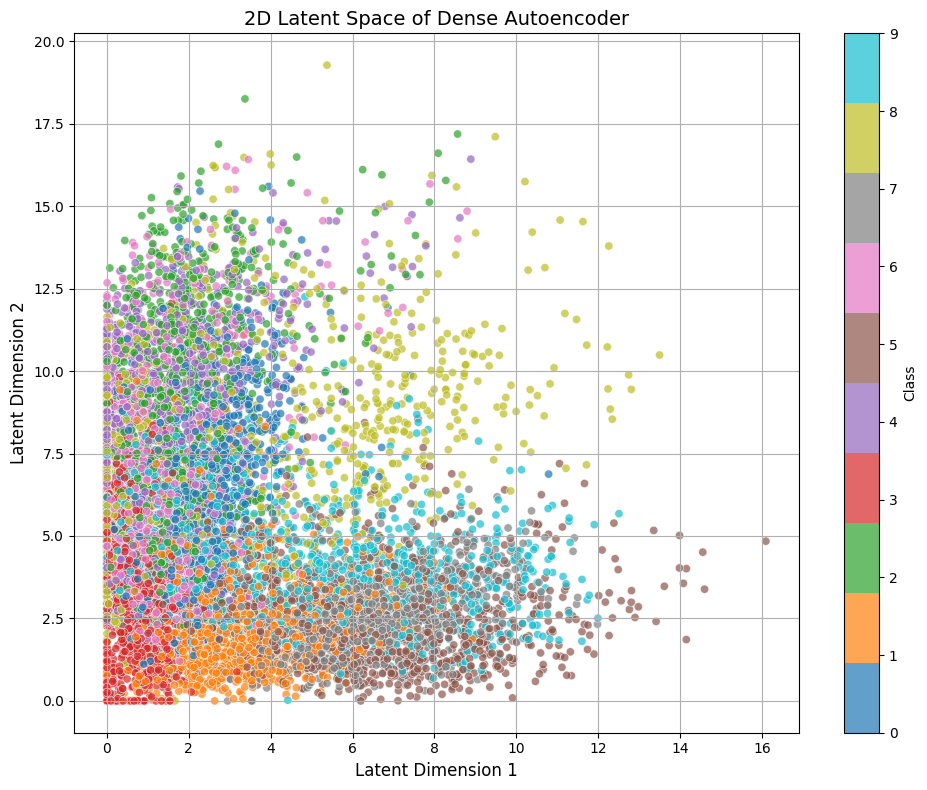

In [169]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolors='w', linewidths=0.5)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.title("2D Latent Space of Dense Autoencoder", fontsize=14)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
sample_vector = np.array([[6, 11]+ [0]*30])

In [171]:
decoded_example = decoder.predict(sample_vector)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [172]:
decoded_image = decoded_example.reshape(28, 28)

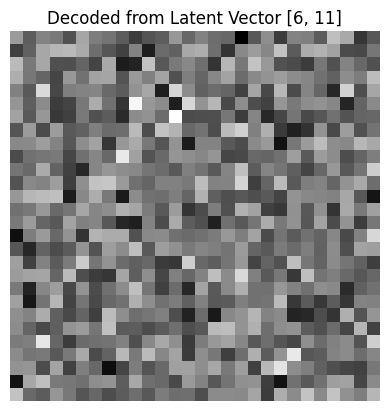

In [173]:
plt.imshow(decoded_image, cmap='gray')
plt.title("Decoded from Latent Vector [6, 11]")
plt.axis('off')
plt.show()

### 5.3 Calculate label ranking average precision (LRAP) score

In [174]:
classifier_output = Dense(10, activation='softmax')(encoded)

In [175]:
classifier = Model(inputs=input_img, outputs=classifier_output)

In [176]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [177]:
classifier.fit(train_X1, train_y, epochs=10, batch_size=64, validation_data=(test_X1, test_y))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6743 - loss: 1.0635 - val_accuracy: 0.8494 - val_loss: 0.4143
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8623 - loss: 0.3719 - val_accuracy: 0.8679 - val_loss: 0.3689
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8792 - loss: 0.3251 - val_accuracy: 0.8689 - val_loss: 0.3641
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8903 - loss: 0.2979 - val_accuracy: 0.8718 - val_loss: 0.3446
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8946 - loss: 0.2825 - val_accuracy: 0.8797 - val_loss: 0.3355
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8999 - loss: 0.2701 - val_accuracy: 0.8772 - val_loss: 0.3376
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9048 - loss: 0.2550 - val_accuracy: 0.8818 - val_loss: 0.3292
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9071 - loss: 0.2422 - val_accurac

In [178]:
true_y = label_binarize(np.argmax(test_y, axis=1), classes=range(10))

In [179]:
score_y = classifier.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [180]:
lrap = label_ranking_average_precision_score(true_y, score_y)
print(f"LRAP Score: {lrap:.4f}")

LRAP Score: 0.9376


## 6.0 Deployment

Paper: ComfortJDDS8150-2 - Autoencoding Fashion MNIST Data